In [19]:
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Loading Dataset

Considering only more than 3 sec files and
labelling the files as Normal or Abnormal

TODO: Add artifacts (i.e. noises without heartbeat data) and ask the user to try again

In [2]:
dataset = []
for folder in ["./set_a/**","./set_b/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            duration = librosa.get_duration(filename=filename)
            # skip audio smaller than 3 secs
            if duration>=3:
                slice_size = 3
                iterations = int((duration-slice_size)/(slice_size-1))
                iterations += 1
#                 initial_offset = (duration % slice_size)/2
                initial_offset = (duration - ((iterations*(slice_size-1))+1))/2
                if label not in ["Aunlabelledtest", "Bunlabelledtest", "artifact"]:
                    for i in range(iterations):
                        offset = initial_offset + i*(slice_size-1)
                        if (label == "normal"):
                            dataset.append({
                                "filename": filename,
                                "label": "normal",
                                "offset": offset
                            })
                        else:
                            dataset.append({
                                "filename": filename,
                                "label": "abnormal",
                                "offset": offset
                            })
                        
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1281 entries, 1241 to 1126
Data columns (total 3 columns):
filename    1281 non-null object
label       1281 non-null object
offset      1281 non-null float64
dtypes: float64(1), object(2)
memory usage: 40.0+ KB


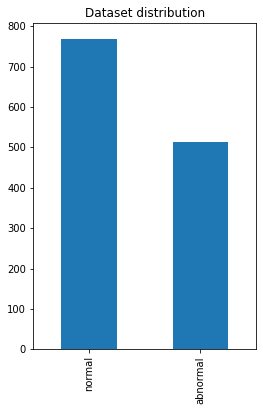

In [3]:
plt.figure(figsize=(4,6))
dataset.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show()

## Split dataset in train and test
80-20 Ratio

In [4]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 1024
Test: 257


## Visualising the data and features

./set_a/murmur__201108222246.wav
./set_b/normal__127_1306764300147_A.wav


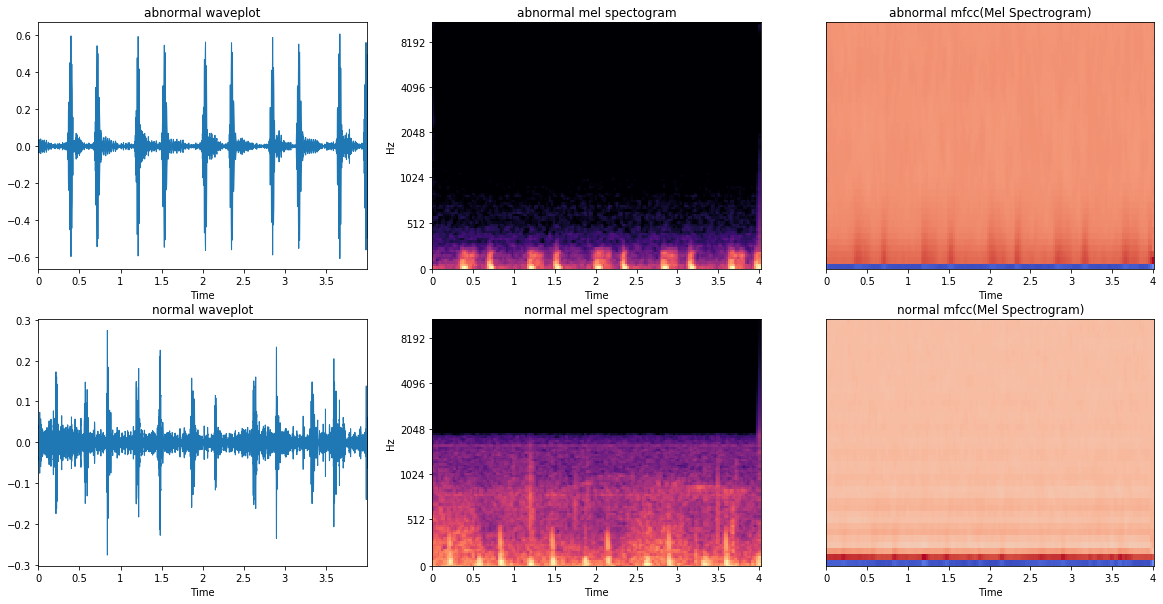

In [5]:
plt.figure(figsize=(20,10))
idx = 0
for label in dataset.label.unique():    
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[33], duration=3)
    print(dataset[dataset.label==label].filename.iloc[33])
    
    # Wave plot
    idx+=1
    plt.subplot(2, 3, idx)
    plt.title("%s waveplot" % label)
    librosa.display.waveplot(y, sr=sr)

    # Mel Spectrogram
    idx+=1
    plt.subplot(2, 3, idx)
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.title("%s mel spectogram" % label)

    # MFCC (Mel spectrogram)
    idx+=1
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)
    plt.subplot(2, 3, idx)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title("%s mfcc(Mel Spectrogram)" % label)
plt.show()

## Extracting features

In [6]:
def extract_features(audio_path,offset):
#     y, sr = librosa.load(audio_path, duration=3)
    y, sr = librosa.load(audio_path, offset=offset, duration=3)
#     y = librosa.util.normalize(y)
    
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, 
                                   hop_length=512, 
                                   n_mels=128)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)

#     mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfccs

In [7]:
x_train = []
x_test = []

for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx],train.offset.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx],test.offset.iloc[idx]))
    
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

print("X train:", x_train.shape)
print("X test:", x_test.shape)

100%|██████████| 257/257 [00:20<00:00, 12.62it/s]

X train: (1024, 40, 130)
X test: (257, 40, 130)


In [8]:
# Encode Labels
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)

## Input Shapes

In [9]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (1024, 40, 130, 1)
Y train: (1024, 2)
X test: (257, 40, 130, 1)
Y test: (257, 2)


## Building Model

In [10]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 39, 129, 16)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 64, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 63, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 31, 32)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 31, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 30, 64)       

## Compiling Model

In [11]:
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

## Fitting Model

In [12]:
%%time
history = model.fit(x_train, y_train,
              batch_size=128,
              epochs=300,
              validation_data=(x_test, y_test),
              class_weight=class_weights,
              shuffle=True)


Train on 1024 samples, validate on 257 samples
Epoch 1/300
1024/1024 [==============================] - 2s 2ms/step - loss: 8.1785 - accuracy: 0.5059 - val_loss: 0.6467 - val_accuracy: 0.6031
Epoch 2/300
1024/1024 [==============================] - 1s 1ms/step - loss: 3.4987 - accuracy: 0.6016 - val_loss: 1.0331 - val_accuracy: 0.3891
Epoch 3/300
1024/1024 [==============================] - 1s 1ms/step - loss: 2.6846 - accuracy: 0.5293 - val_loss: 1.1105 - val_accuracy: 0.6109
Epoch 4/300
1024/1024 [==============================] - 1s 1ms/step - loss: 1.9415 - accuracy: 0.5635 - val_loss: 0.7511 - val_accuracy: 0.5175
Epoch 5/300
1024/1024 [==============================] - 1s 1ms/step - loss: 1.4412 - accuracy: 0.5625 - val_loss: 0.6332 - val_accuracy: 0.6187
Epoch 6/300
1024/1024 [==============================] - 1s 1ms/step - loss: 1.0230 - accuracy: 0.6006 - val_loss: 0.6269 - val_accuracy: 0.6654
Epoch 7/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.971

1024/1024 [==============================] - 1s 1ms/step - loss: 0.5433 - accuracy: 0.7275 - val_loss: 0.5643 - val_accuracy: 0.7160
Epoch 56/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.5275 - accuracy: 0.7383 - val_loss: 0.5615 - val_accuracy: 0.7160
Epoch 57/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.5346 - accuracy: 0.7285 - val_loss: 0.5644 - val_accuracy: 0.7121
Epoch 58/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.5325 - accuracy: 0.7256 - val_loss: 0.5637 - val_accuracy: 0.7043
Epoch 59/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.5373 - accuracy: 0.7305 - val_loss: 0.5641 - val_accuracy: 0.7237
Epoch 60/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.5298 - accuracy: 0.7539 - val_loss: 0.5645 - val_accuracy: 0.7198
Epoch 61/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.5021 - accuracy: 0.7490 - val_loss: 0.5592 - val_accuracy

1024/1024 [==============================] - 1s 1ms/step - loss: 0.4718 - accuracy: 0.7832 - val_loss: 0.5270 - val_accuracy: 0.7354
Epoch 112/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.4583 - accuracy: 0.7832 - val_loss: 0.5133 - val_accuracy: 0.7471
Epoch 113/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.4573 - accuracy: 0.7842 - val_loss: 0.5157 - val_accuracy: 0.7510
Epoch 114/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.4544 - accuracy: 0.7842 - val_loss: 0.5190 - val_accuracy: 0.7471
Epoch 115/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.4620 - accuracy: 0.7773 - val_loss: 0.5251 - val_accuracy: 0.7471
Epoch 116/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.4547 - accuracy: 0.7861 - val_loss: 0.5225 - val_accuracy: 0.7354
Epoch 117/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.4437 - accuracy: 0.7959 - val_loss: 0.5174 - val_ac

Epoch 167/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.3844 - accuracy: 0.8174 - val_loss: 0.4729 - val_accuracy: 0.7704
Epoch 168/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.3916 - accuracy: 0.8203 - val_loss: 0.4739 - val_accuracy: 0.7704
Epoch 169/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.3909 - accuracy: 0.8271 - val_loss: 0.4737 - val_accuracy: 0.7471
Epoch 170/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.4104 - accuracy: 0.8066 - val_loss: 0.4689 - val_accuracy: 0.7782
Epoch 171/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.3900 - accuracy: 0.8193 - val_loss: 0.4717 - val_accuracy: 0.7626
Epoch 172/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.3998 - accuracy: 0.8105 - val_loss: 0.4720 - val_accuracy: 0.7704
Epoch 173/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.3861 - accuracy: 0.8203 - val_loss: 0

Epoch 223/300
1024/1024 [==============================] - 2s 2ms/step - loss: 0.3387 - accuracy: 0.8438 - val_loss: 0.4194 - val_accuracy: 0.7938
Epoch 224/300
1024/1024 [==============================] - 2s 2ms/step - loss: 0.3275 - accuracy: 0.8633 - val_loss: 0.4209 - val_accuracy: 0.7821
Epoch 225/300
1024/1024 [==============================] - 2s 2ms/step - loss: 0.3132 - accuracy: 0.8623 - val_loss: 0.4273 - val_accuracy: 0.7782
Epoch 226/300
1024/1024 [==============================] - 2s 2ms/step - loss: 0.3339 - accuracy: 0.8525 - val_loss: 0.4149 - val_accuracy: 0.7938
Epoch 227/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.3336 - accuracy: 0.8340 - val_loss: 0.4147 - val_accuracy: 0.7860
Epoch 228/300
1024/1024 [==============================] - 2s 1ms/step - loss: 0.3373 - accuracy: 0.8516 - val_loss: 0.4117 - val_accuracy: 0.7860
Epoch 229/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.3158 - accuracy: 0.8555 - val_loss: 0

Epoch 279/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.2624 - accuracy: 0.8857 - val_loss: 0.3703 - val_accuracy: 0.8249
Epoch 280/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.2574 - accuracy: 0.8857 - val_loss: 0.3716 - val_accuracy: 0.8288
Epoch 281/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.2693 - accuracy: 0.8799 - val_loss: 0.3761 - val_accuracy: 0.8210
Epoch 282/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.2559 - accuracy: 0.8809 - val_loss: 0.3663 - val_accuracy: 0.8171
Epoch 283/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.2824 - accuracy: 0.8721 - val_loss: 0.3952 - val_accuracy: 0.7860
Epoch 284/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.2694 - accuracy: 0.8779 - val_loss: 0.3582 - val_accuracy: 0.8327
Epoch 285/300
1024/1024 [==============================] - 1s 1ms/step - loss: 0.2768 - accuracy: 0.8789 - val_loss: 0

## Evaluating model

Text(0.5, 1.0, 'Accuracy Curves')

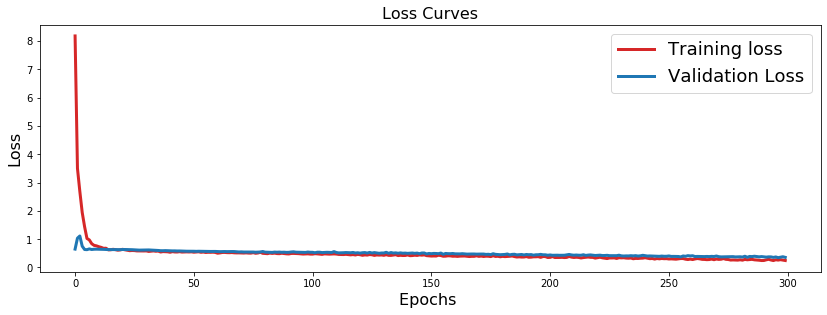

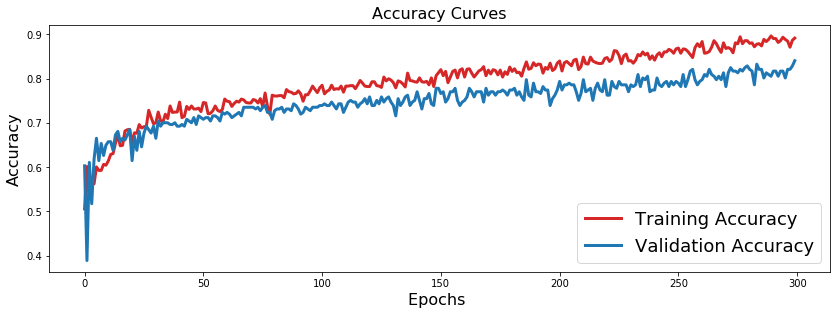

In [13]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_loss'],'#1f77b4',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'#1f77b4',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [14]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

257/257 [==============================] - 0s 228us/step
Test loss: 0.35465695793062796
Test accuracy: 0.8404669165611267


In [15]:
predictions = model.predict(x_test, verbose=1)

y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))

257/257 [==============================] - 0s 444us/step
              precision    recall  f1-score   support

    abnormal       0.78      0.80      0.79        97
      normal       0.88      0.86      0.87       160

    accuracy                           0.84       257
   macro avg       0.83      0.83      0.83       257
weighted avg       0.84      0.84      0.84       257



### Save Model and Weights

In [16]:
model_name = "heartbeat_classifier (normalised).h5"
model.save(model_name)

In [17]:
# 1 sec overlap
# Trained for 3sec for files >3sec

### Classifying an heart beat

In [18]:
# # load and evaluate a saved model
# from keras.models import load_model
 
# # load model
# model = load_model("trained_heartbeat_classifier.h5")

# # File to be classified
# classify_file = "my_heartbeat.wav"
# x_test = []
# x_test.append(extract_features(classify_file,0.5))
# x_test = np.asarray(x_test)
# x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
# pred = model.predict(x_test,verbose=1)

# print(pred)

1/1 [==============================] - 0s 89ms/step
[[0.03617344 0.9638266 ]]


In [31]:
# pred_class = model.predict_classes(x_test)
# if pred_class[0]:
#     print("Normal heartbeat")
#     print("confidence:",pred[0][1])
# else:
#     print("Abnormal heartbeat")
#     print("confidence:",pred[0][0])

Normal heartbeat
confidence: 0.9638266
